### 加载库，载入数据

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("power_ai.csv")
df.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


### 格式转换

In [9]:
df['record_date'] = pd.to_datetime(df['record_date'])
df.loc[(df.user_id==1416) & (df.record_date>'20160731'),'power_consumption'] = 1216933.0
df.head()

,user_id,record_date,power_consumption
0,1,2015-01-01,1135.0
1,1,2015-01-02,570.0
2,1,2015-01-03,3418.0
3,1,2015-01-04,3968.0
4,1,2015-01-05,3986.0


## baseline 1：直接统计平均

In [10]:
base_df = df[['record_date','power_consumption']].groupby(by='record_date').agg('sum')
base_df = base_df.reset_index()
base_df.head()

,record_date,power_consumption
0,2015-01-01,2900575.0
1,2015-01-02,3158211.0
2,2015-01-03,3596487.0
3,2015-01-04,3939672.0
4,2015-01-05,4101790.0


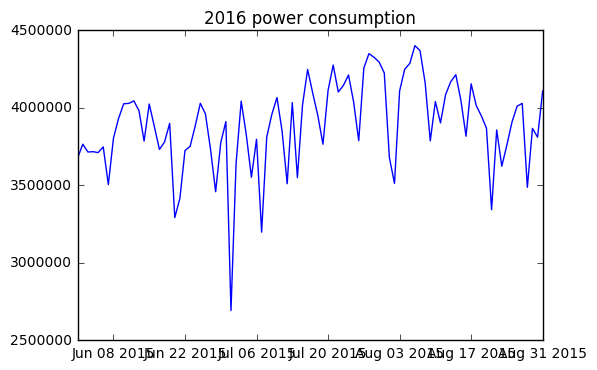

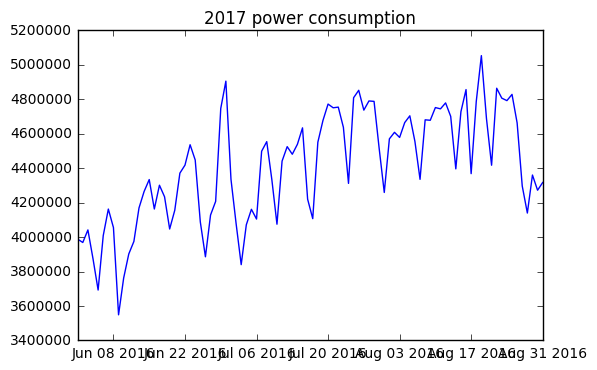

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
#trend = base_df[(base_df.record_date>='2015-07-01')&(base_df.record_date<'2015-10-01')]
trend = base_df[(base_df.record_date>='2015-06-01')&(base_df.record_date<'2015-09-01')]
plt.plot(trend['record_date'], trend['power_consumption'])
plt.title('2016 power consumption')
plt.show()
trend2 = base_df[(base_df.record_date>='2016-06-01')&(base_df.record_date<'2016-09-01')]
plt.plot(trend2['record_date'], trend2['power_consumption'])
plt.title('2017 power consumption')
plt.show()

In [12]:
num1 = base_df[(base_df.record_date<='2015-06-30')&(base_df.record_date>='2015-06-24')]['power_consumption'].sum()
num1 = num1/7

num2 = base_df[(base_df.record_date<='2015-07-31')&(base_df.record_date>='2015-07-25')]['power_consumption'].sum()
num2 = num2/7

num3 = base_df[(base_df.record_date<='2015-08-31')&(base_df.record_date>='2015-08-25')]['power_consumption'].sum()
num3 = num3/7

In [13]:
diff = (num1+num2-2*num3)/2
diff

113068.78571428591

In [14]:
commit_tmp_df = base_df[(base_df.record_date>='2016-07-01') & (base_df.record_date<'2016-09-01')].copy()
commit_tmp_df['day'] = base_df['record_date'].apply(lambda x: x.day)
commit_tmp_df = commit_tmp_df[['power_consumption','day']].groupby(by='day').agg('sum')
commit_tmp_df = pd.DataFrame(commit_tmp_df.reset_index())

predict_df = pd.date_range('2016/9/1', periods=31, freq='D')
predict_df = pd.DataFrame(predict_df)
predict_df.columns = ['predict_date']
predict_df['predict_power_consumption'] = commit_tmp_df['power_consumption']/2
predict_df['predict_power_consumption'] = predict_df['predict_power_consumption'].astype('int')
predict_df['predict_power_consumption'] -= diff
predict_df = predict_df[(predict_df.predict_date<'2016-10-01')]
predict_df['predict_date'] = predict_df['predict_date'].astype(str).apply(lambda x: x.replace("-",""))
predict_df.to_csv('Tianchi_power_predict_table.csv',index=False)

### 统计方差和均值

In [15]:
df2 = df[['user_id','power_consumption']].groupby(by='user_id').agg(['mean','median','var'])

In [16]:
df2.reset_index(col_level=1)
df2.columns = df2.columns.get_level_values(1)
df2 = df2.reset_index()
df2.head()

,user_id,mean,median,var
0,1,665.870279,443.0,8.242558e+05
1,2,238.164204,254.0,1.060840e+04
2,3,508.556650,531.0,3.956464e+04
3,4,2256.428571,735.0,6.956167e+06
4,5,1096.886700,1021.0,3.702587e+05


## baseline 2：特征工程+lightGBM

### baseline 2.1 直接对每天的总量进行回归拟合

In [17]:
df_test = base_df[(base_df.record_date>='2016-08-01')&(base_df.record_date<='2016-08-30')]
df_test['record_date'] = pd.DataFrame(df_test['record_date']+pd.Timedelta('31 days'))
df_test.head()

,record_date,power_consumption
578,2016-09-01,4570506.0
579,2016-09-02,4608467.0
580,2016-09-03,4578734.0
581,2016-09-04,4665000.0
582,2016-09-05,4704315.0


In [18]:
base_df = pd.concat([base_df, df_test]).sort_values(['record_date'])

In [19]:
base_df['dow'] = base_df['record_date'].apply(lambda x: x.dayofweek)
base_df['doy'] = base_df['record_date'].apply(lambda x: x.dayofyear)
base_df['day'] = base_df['record_date'].apply(lambda x: x.day)
base_df['month'] = base_df['record_date'].apply(lambda x: x.month)
base_df['year'] = base_df['record_date'].apply(lambda x: x.year)

In [20]:
def map_season(month):
    month_dic = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:3, 9:3, 10:4, 11:4, 12:1}
    return month_dic[month]

base_df['season'] = base_df['month'].apply(lambda x: map_season(x))

In [21]:
base_df.head()

,record_date,power_consumption,dow,doy,day,month,year,season
0,2015-01-01,2900575.0,3,1,1,1,2015,1
1,2015-01-02,3158211.0,4,2,2,1,2015,1
2,2015-01-03,3596487.0,5,3,3,1,2015,1
3,2015-01-04,3939672.0,6,4,4,1,2015,1
4,2015-01-05,4101790.0,0,5,5,1,2015,1


In [35]:
base_df_stats = new_df = base_df[['power_consumption','year','month']].groupby(by=['year', 'month']).agg(['mean', 'std'])
base_df_stats.head()

power_consumption               
                        mean            std
year month                                 
2015 1          3.961383e+06  303629.486622
     2          2.795163e+06  769697.864999
     3          3.478852e+06  564753.747993
     4          3.768333e+06  190787.832757
     5          3.755262e+06  269088.249265

In [36]:
base_df_stats.columns = base_df_stats.columns.droplevel(0)
base_df_stats = base_df_stats.reset_index()
base_df_stats.head()

,year,month,mean,std
0,2015,1,3.961383e+06,303629.486622
1,2015,2,2.795163e+06,769697.864999
2,2015,3,3.478852e+06,564753.747993
3,2015,4,3.768333e+06,190787.832757
4,2015,5,3.755262e+06,269088.249265


In [37]:
base_df_stats['1_m_mean'] = base_df_stats['mean'].shift(1)
base_df_stats['2_m_mean'] = base_df_stats['mean'].shift(2)
base_df_stats['1_m_std'] = base_df_stats['std'].shift(1)
base_df_stats['2_m_std'] = base_df_stats['std'].shift(2)
base_df_stats.head()

,year,month,mean,std,1_m_mean,2_m_mean,1_m_std,2_m_std
0,2015,1,3.961383e+06,303629.486622,NaN,NaN,NaN,NaN
1,2015,2,2.795163e+06,769697.864999,3.961383e+06,NaN,303629.486622,NaN
2,2015,3,3.478852e+06,564753.747993,2.795163e+06,3.961383e+06,769697.864999,303629.486622
3,2015,4,3.768333e+06,190787.832757,3.478852e+06,2.795163e+06,564753.747993,769697.864999
4,2015,5,3.755262e+06,269088.249265,3.768333e+06,3.478852e+06,190787.832757,564753.747993


In [38]:
data_df = pd.merge(base_df, base_df_stats[['year', 'month', '1_m_mean', '2_m_mean', '1_m_std', '2_m_std']], how='inner', on=['year', 'month'])
data_df = data_df[~pd.isnull(data_df['2_m_mean'])]

In [39]:
data_df.tail()

,record_date,power_consumption,dow,doy,day,month,year,season,1_m_mean,2_m_mean,1_m_std,2_m_std
634,2016-09-26,4662827.0,0,270,26,9,2016,3,4612634.0,4.458408e+06,215769.810349,276925.542329
635,2016-09-27,4296735.0,1,271,27,9,2016,3,4612634.0,4.458408e+06,215769.810349,276925.542329
636,2016-09-28,4139782.0,2,272,28,9,2016,3,4612634.0,4.458408e+06,215769.810349,276925.542329
637,2016-09-29,4360483.0,3,273,29,9,2016,3,4612634.0,4.458408e+06,215769.810349,276925.542329
638,2016-09-30,4272193.0,4,274,30,9,2016,3,4612634.0,4.458408e+06,215769.810349,276925.542329


In [27]:
data_df.to_csv('./data_all_20170524.csv', index=False)

In [40]:
train_data = data_df[data_df.record_date<'2016-09-01']\
[['dow','doy','day','month','year','season','1_m_mean','2_m_mean','1_m_std','2_m_std']]

test_data = data_df[data_df.record_date>='2016-09-01']\
[['dow','doy','day','month','year','season','1_m_mean','2_m_mean','1_m_std','2_m_std']]

train_target = data_df[data_df.record_date<'2016-09-01'][['power_consumption']]

In [45]:
train_lgb = train_data.copy()
print(train_lgb.dtypes)
train_lgb[['dow','doy','day','month','year','season']] = train_lgb[['dow','doy','day','month','year','season']]\
.astype(str)
test_lgb = test_data.copy()
test_lgb[['dow','doy','day','month','year','season']] = test_lgb[['dow','doy','day','month','year','season']]\
.astype(str)
print(train_lgb.dtypes)

dow           int64
doy           int64
day           int64
month         int64
year          int64
season        int64
1_m_mean    float64
2_m_mean    float64
1_m_std     float64
2_m_std     float64
dtype: object
dow          object
doy          object
day          object
month        object
year         object
season       object
1_m_mean    float64
2_m_mean    float64
1_m_std     float64
2_m_std     float64
dtype: object


In [42]:
X_lgb = train_lgb.values
y_lgb = train_target.values.reshape(train_target.values.shape[0],)

In [31]:
X_lgb[0,:]

array(['6', '60', '1', '3', '2015', '2', 2795163.0535714286,
       3961383.0967741935, 769697.8649992085, 303629.48662213905], dtype=object)

In [34]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMRegressor(colsample_bytree=0.8, subsample=0.9, subsample_freq=5)

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [100, 200, 400, 800, 1000, 1200, 1500, 2000],
    'num_leaves':[128, 1024, 4096]
}

#fit_params = {'sample_weight':, 'early_stopping_rounds':5, 'categorical_feature':[0,1,2,3,4,5]}
#fit_params = {'early_stopping_rounds':5, 'categorical_feature':[0,1,2,3,4,5]}
fit_params = {'categorical_feature':[0,1,2,3,4,5]}

gbm = GridSearchCV(estimator, param_grid, fit_params=fit_params)

gbm.fit(X_lgb, y_lgb)

print "----------------------cv results--------------------------"
print gbm.cv_results_

print "----------------------------cv------------------------------"
print gbm.cv

print('Best parameters found by grid search are:', gbm.best_params_)

OSError: dlopen(/Users/fay/anaconda/lib/python2.7/site-packages/lightgbm/lib_lightgbm.so, 6): Library not loaded: /usr/local/opt/gcc/lib/gcc/8/libgomp.1.dylib
  Referenced from: /Users/fay/anaconda/lib/python2.7/site-packages/lightgbm/lib_lightgbm.so
  Reason: image not found

### 选择loss function和调整权重

In [26]:
weights = 10000000.0/train_target.values.reshape(train_target.values.shape[0],)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

estimator = lgb.LGBMRegressor(colsample_bytree=0.8, subsample=0.9, subsample_freq=5, objective='regression_l1')

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
    'n_estimators': [800, 1000, 1500, 2000, 2500],
    'num_leaves':[128, 1024, 4096]
}

#fit_params = {'sample_weight':, 'early_stopping_rounds':5, 'categorical_feature':[0,1,2,3,4,5]}
#fit_params = {'early_stopping_rounds':5, 'categorical_feature':[0,1,2,3,4,5]}
fit_params = {'sample_weight': weights, 'categorical_feature':[0,1,2,3,4,5]}

gbm = GridSearchCV(estimator, param_grid, fit_params=fit_params)

gbm.fit(X_lgb, y_lgb)

print "----------------------cv results--------------------------"
print gbm.cv_results_

print "----------------------------cv------------------------------"
print gbm.cv

print('Best parameters found by grid search are:', gbm.best_params_)

In [27]:
#随机敲定一组参数跑模型
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_lgb, y_lgb)
# specify your configurations as a dict
params = {
    'num_leaves': 128,
    'learning_rate':0.01,
    'n_estimators':800,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'weight': weights,
    'application':'regression_l1'
}

print('Start training...')
# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=800,
                feature_name=['f' + str(i + 1) for i in range(X_lgb.shape[1])],
                categorical_feature=[0,1,2,3,4,5])

Start training...


Plot feature importances...


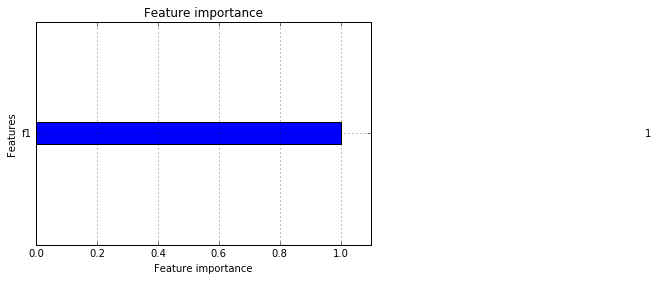

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=50)
plt.show()

In [38]:
commit_df = pd.date_range('2016/9/1', periods=30, freq='D')
commit_df = pd.DataFrame(commit_df)
commit_df.columns = ['predict_date']
y_predict = gbm.predict(test_lgb.values)
commit_df['predict_power_consumption'] = pd.DataFrame(y_predict).astype('int')
commit_df.head()

,predict_date,predict_power_consumption
0,2016-09-01,3894801
1,2016-09-02,3879117
2,2016-09-03,3826443
3,2016-09-04,3727352
4,2016-09-05,3866033


In [39]:
commit_df['predict_date'] = commit_df['predict_date'].astype(str).apply(lambda x: x.replace("-",""))
commit_df.to_csv('Tianchi_power_predict_table_20170519_v2.csv',index=False)